# CSE 572: Lab 8

In this lab, you will practice implementing feed-forward and convolutional neural networks.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

In [636]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# Set the random seed for reproducibility
seed = 0
tf.random.set_seed(seed)

## Feed-forward neural networks

### Load the dataset

For this example, we will use the [Cleveland Heart Disease dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease). Review the dataset documentation to learn more about the attributes and other aspects of the dataset. The dataset consists of a CSV file with 303 rows. Each row contains information about a patient. There are 14 attribute columns and one binary class column (`target`) that reports whether or not a patient had a heart disease. We will train a feed-forward neural network model to predict whether or not a given patient has a heart disease based on the attribute values.

In [637]:
# Load the dataset
data = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [638]:
# Print sample rows
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [639]:
# Print the number of rows and columns
data.shape

(303, 14)

Split the dataset into three randomly-sampled subsets: training (60%), validation (20%), and test (20%). Use the `seed` variable for the `random_state`.

In [640]:
# YOUR CODE HERE

# train = data.sample(frac=0.6, random_state=seed)
# data_remaining = data.drop(train.index)
# val = data_remaining.sample(frac=0.5, random_state=seed)
# test = data_remaining.drop(val.index)

train, val, test = np.split(data.sample(frac=1, random_state=seed), [int(.6*len(data)), int(.8*len(data))])

Print the number of samples in each of the three subsets and the number of instances from each class. For example, for the training set you might print "The training set has __ instances (__ heart disease, __ no disease)".

In [641]:
# YOUR CODE HERE
print('Training set has {} instances ({} heart disease, {} no disease)'.format(train.shape[0],
                                                                   train[train['target']==1].shape[0],
                                                                   train[train['target']==0].shape[0]))

print('Validation set has {} instances ({} heart disease, {} no disease)'.format(val.shape[0],
                                                                   val[val['target']==1].shape[0],
                                                                   val[val['target']==0].shape[0]))

print('Testing set has {} instances ({} heart disease, {} no disease)'.format(test.shape[0],
                                                                   test[test['target']==1].shape[0],
                                                                   test[test['target']==0].shape[0]))

Training set has 181 instances (48 heart disease, 133 no disease)
Validation set has 61 instances (18 heart disease, 43 no disease)
Testing set has 61 instances (17 heart disease, 44 no disease)


### Prepare the dataset

Before we can feed this dataset to our model for training and evaluation, we need to perform a few steps to get it ready:
1. Convert the dataframes to Dataset objects
2. Normalize the numerical feature values
3. Binarize the Categorical features by converting to one-hot encodings

In [642]:
# Convert dataframes to Dataset objects
def dataframe_to_dataset(df):
    df = df.copy()
    # Remove the target column and store in a separate array
    labels = df.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=False)
    return ds


train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

The Dataset object yields a tuple containing the input feature vector and target (class value): `(input, target)`. `input` is a dictionary of features and `target` is the value 0 or 1. The code below prints an example instance drawn from the training Dataset object.

In [643]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("\nTarget:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=135>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=252>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=172>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}

Target: tf.Tensor(0, shape=(), dtype=int64)


We can use the batch() function in keras to create batches from the full dataset for passing to the model. For the training dataset, we'll define a hyperparameter `batch_size` that we will set. For the validation and test sets, we will make the batch size equivalent to the size of the subset so all samples in that subset are evaluated each time the dataset is evaluated by the model.

In [644]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(val.shape[0])
test_ds = test_ds.batch(test.shape[0])

There are seven categorical features in the dataset: `sex`, `cp`, `fbs`, `restecg`, `exang`, `ca`, and `thal`. You can read more about what these features mean in the [dataset documentation](https://archive.ics.uci.edu/ml/datasets/heart+Disease). All of them except `thal` have integer data type while `thal` has String data type. Below we define a function to encode these feature values as one-hot encodings using the [IntegerLookup()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup) and [StringLookup()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) layers. These layers create look-up tables for mapping a set of arbitrary integers or strings to a one-hot encoding. We use an `is_string` argument to indicate whether we should use the `StringLookup()` for `thal` or the `IntegerLookup()` for the remaining features.

In [645]:
def encode_categorical_feature(feature, name, dataset, is_string):
    from tensorflow.keras.layers import IntegerLookup
    from tensorflow.keras.layers import StringLookup
    
    # Create lookup layer to turn categorical features into 1-hot integer encodings
    if is_string:
        lookup = StringLookup(output_mode="binary")
    else:
        lookup = IntegerLookup(output_mode="binary")

    # Prepare a Dataset that only yields the feature of interest
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Find the set of possible values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

The remaining features in the dataset (`age`, `trestbps`, `chol`, `thalach`, `oldpeak`, and `slope`) are all numerical measurements. You can read more about what these features mean in the [dataset documentation](https://archive.ics.uci.edu/ml/datasets/heart+Disease). We don't need to encode the numerical features, but we do want to scale them to the same range of values (e.g., using standardization or normalization). Below we define a function that uses the [Normalization()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) layer to standardize the data (subtract the mean and divide by the standard deviation for each feature).

In [646]:
def normalize(feature, name, dataset):
    from tensorflow.keras.layers import Normalization
    
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields the feature of interest
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    norm_feature = normalizer(feature)
    return norm_feature

Now we can apply these functions to each of our features and return an encoded/preprocessed input layer. We first create tensor variables for each of the inputs, then apply the appropriate function, then concatenate all of these input layers for each feature together to form a single input feature layer.

In [647]:
all_inputs = [
    keras.Input(shape=(1,), name="sex", dtype="int64"),
    keras.Input(shape=(1,), name="cp", dtype="int64"),
    keras.Input(shape=(1,), name="fbs", dtype="int64"),
    keras.Input(shape=(1,), name="restecg", dtype="int64"),
    keras.Input(shape=(1,), name="exang", dtype="int64"),
    keras.Input(shape=(1,), name="ca", dtype="int64"),
    keras.Input(shape=(1,), name="thal", dtype="string"),
    keras.Input(shape=(1,), name="age"),
    keras.Input(shape=(1,), name="trestbps"),
    keras.Input(shape=(1,), name="chol"),
    keras.Input(shape=(1,), name="thalach"),
    keras.Input(shape=(1,), name="oldpeak"),
    keras.Input(shape=(1,), name="slope"),
]

In [648]:
feature_layer = layers.concatenate(
    [
        encode_categorical_feature(all_inputs[0], "sex", train_ds, False),
        encode_categorical_feature(all_inputs[1], "cp", train_ds, False),
        encode_categorical_feature(all_inputs[2], "fbs", train_ds, False),
        encode_categorical_feature(all_inputs[3], "restecg", train_ds, False),
        encode_categorical_feature(all_inputs[4], "exang", train_ds, False),
        encode_categorical_feature(all_inputs[5], "ca", train_ds, False),
        encode_categorical_feature(all_inputs[6], "thal", train_ds, True),
        normalize(all_inputs[7], "age", train_ds),
        normalize(all_inputs[8], "trestbps", train_ds),
        normalize(all_inputs[9], "chol", train_ds),
        normalize(all_inputs[10], "thalach", train_ds),
        normalize(all_inputs[11], "oldpeak", train_ds),
        normalize(all_inputs[12], "slope", train_ds)
    ]
)

### Build the model

Now that we've prepared our dataset, we can construct our neural network model. We construct the model by composing Layer objects starting with the input layer (which we've already defined as `feature_layer`) and ending with the output layer (which will be the final output of the model). In this example, we will only use [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers which are simple fully-connected feed-forward layers (i.e., each output from layer `i-1` is connected by a weight variable to every neuron in layer `i`). We will create a network with only one hidden layer (between the input and output layers).

The Dense() layer object allows us to specify the activation function to use using the `activation` argument. In class, we talked about several activation functions including sigmoid, sign, and tanh. Another commonly used activation function is the rectified linear unit, or "ReLU" function. Another commonly used activation function is the rectified linear unit, or "ReLU" function, which has the equation $a(z)=max(0,z)$. We will use `relu` as our activation function in this example for all layers except the final layer, which will use a `sigmoid` activation.

In [649]:
# Create a variable for the number of units/neurons in the layer
h1_units = 32
# Create a Dense layer and append it to the input layer
h1_layer = layers.Dense(h1_units, activation='relu')(feature_layer)

# Create an output layer with one output representing the likelihood of 
# heart disease and append it to the hidden layer
output_layer = layers.Dense(1, activation="sigmoid")(h1_layer)

# Build the model specifying the input and output layer
model = keras.Model(inputs=all_inputs, outputs=output_layer)

We can plot our completed model to visualize the input, hidden, and output layers.

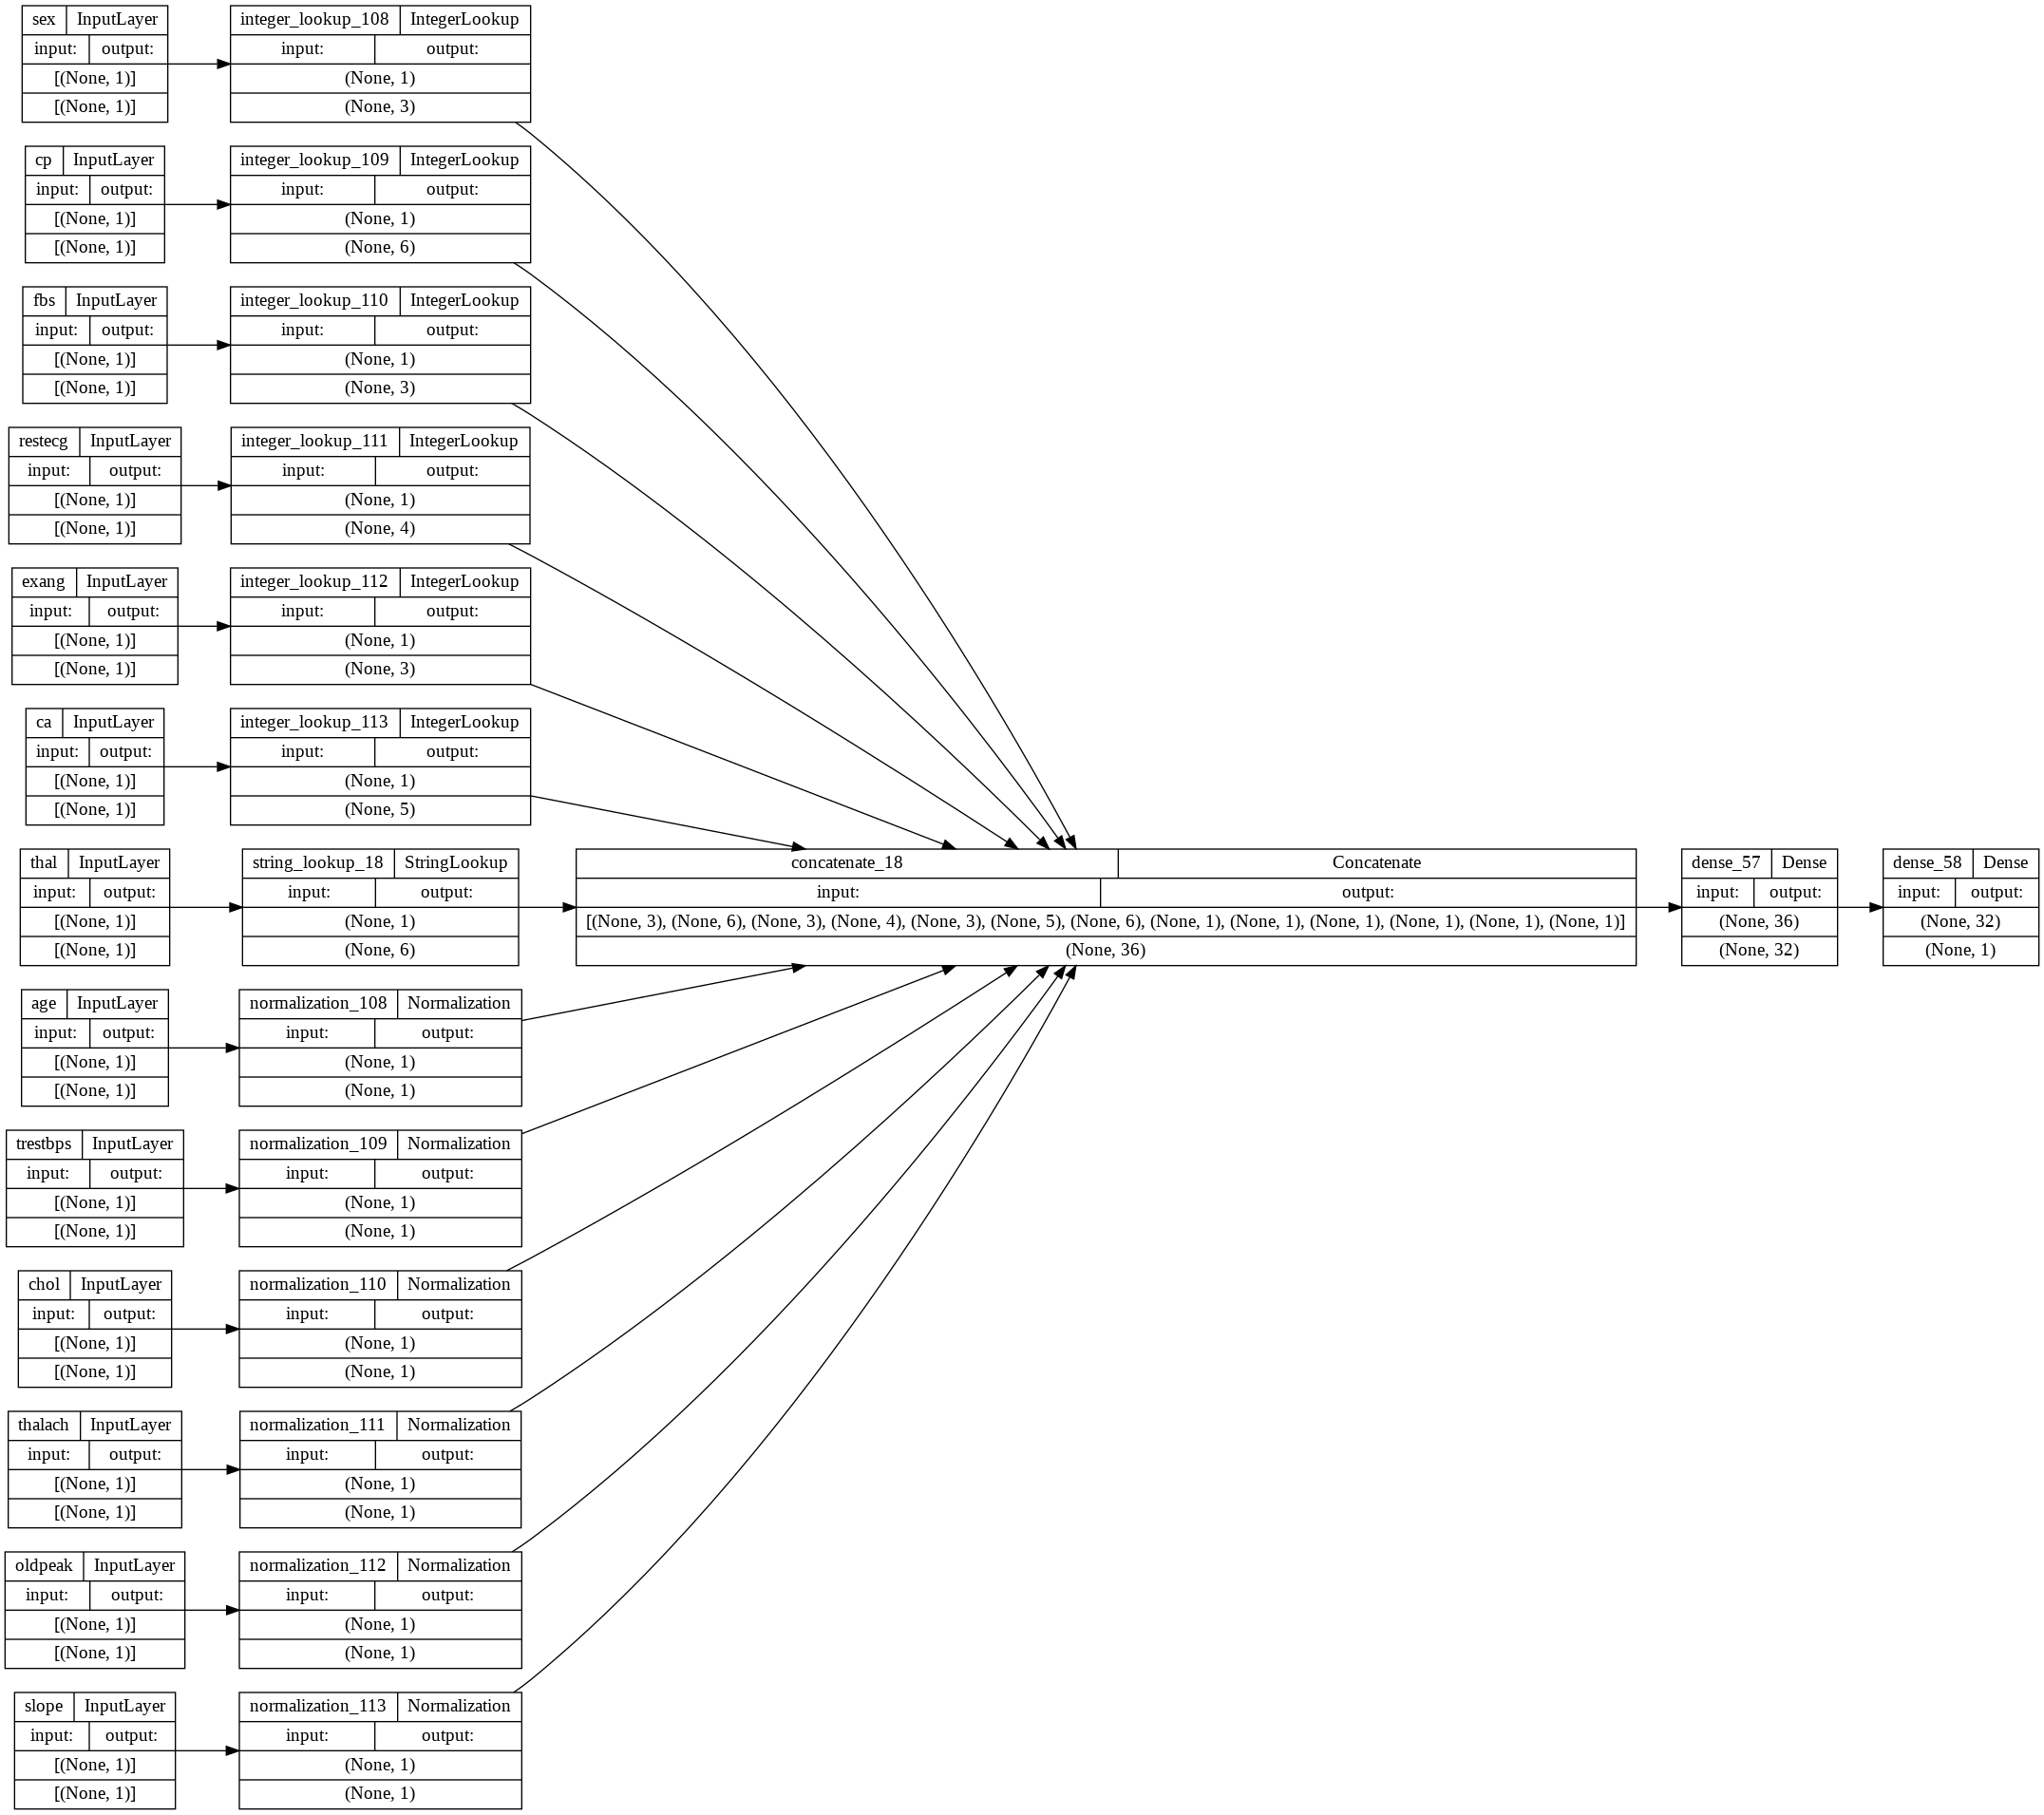

In [650]:
# `rankdir='LR'` is to make the graph horizontal
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next we compile the model by specifying the optimization technique and loss function to be used in model training. We can also specify the metric(s) that will be logged during training. We will use stochastic gradient descent (`sgd`) for the optimizer and binary cross entropy (log loss) as the loss function. We will log the accuracy metric during training. We can also specify the learning rate hyperparameter here.

In [651]:
lr = 0.01
model.compile(keras.optimizers.SGD(learning_rate=lr), "binary_crossentropy", metrics=["accuracy"])

### Train the model

Now that we've constructed and compiled our model, we can train the model using our training dataset. This is done in keras using the `fit()` function, which also gives us an option to provide the validation dataset which will be used to evaluate validation accuracy after every epoch.

In [652]:
model_result = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
6/6 [==============================] - 1s 73ms/step - loss: 0.5750 - accuracy: 0.7624 - val_loss: 0.5773 - val_accuracy: 0.7705
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5595 - accuracy: 0.7680 - val_loss: 0.5649 - val_accuracy: 0.7705
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5455 - accuracy: 0.7845 - val_loss: 0.5536 - val_accuracy: 0.7705
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5329 - accuracy: 0.7845 - val_loss: 0.5432 - val_accuracy: 0.7705
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5214 - accuracy: 0.7845 - val_loss: 0.5336 - val_accuracy: 0.7705
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5109 - accuracy: 0.7845 - val_loss: 0.5246 - val_accuracy: 0.7705
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5012 - accuracy: 0.7845 - val_loss: 0.5162 - val_accuracy: 0.7705
Epoch 8/100
6/6 [=========

The `fit()` function returns a history attribute that gives the metrics recorded during training as a dictionary. We can print the dictionary keys to see which metrics were stored:

In [653]:
model_result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Create a figure with two subplots. The first subplot should plot the training and validation loss (`loss` and `val_loss`) and the second subplot should plot the training and validation accuracy (`accuracy` and `val_accuracy`). Make sure you include the axis labels and a legend in each plot.

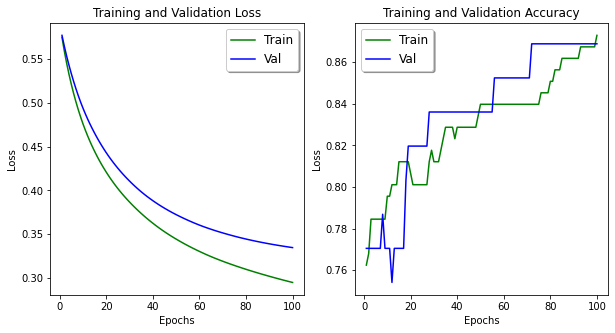

In [654]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
train_loss = model_result.history['loss']
val_loss = model_result.history['val_loss']
epochs = range(1, len(train_loss) + 1)
ax1.plot(epochs, train_loss, 'g', label='Train')
ax1.plot(epochs, val_loss, 'b', label = 'Val')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(shadow=True, fontsize='large')

train_accuracy = model_result.history['accuracy']
val_accuracy = model_result.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)
ax2.plot(epochs, train_accuracy, 'g', label='Train')
ax2.plot(epochs, val_accuracy, 'b', label = 'Val')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(shadow=True, fontsize='large')

**Question 1: If we train our model for too long (too many epochs), we run the risk of overfitting to the training data which will have a negative effect on our model's generalization to the validation dataset. Try changing the number of epochs to 1000 and re-training. Around how many epochs do you see the model begin to overfit?**

**Answer:**

The validation loss goes down until around 200 epochs and then starts to increase again, which indicates the model has begun overfitting. In the accuracy plot, we can see that the validation accuracy increases until around 200 epochs as well, after which it begins to plateau and then decrease even though the training accuracy continues to increase.

### Test the model

Finally, we evaluate our trained model on the held-out test set. First we predict the outputs for the test data.

In [655]:
preds = model.predict(test_ds)

The model output from the final sigmoid layer is a value between 0 and 1 representing the likelihood that a given sample patient has heart disease. To get the predicted classes, we predict 1 if the output was >= 0.5 and 0 otherwise.

In [656]:
pred_classes = [1 if p >= 0.5 else 0 for p in preds]

Compute and print the test accuracy.

In [657]:

from sklearn.metrics import accuracy_score
y_test = test.target
print(accuracy_score(y_test, pred_classes))

0.5573770491803278


**Question 2: There is a large difference between the training and validation accuracies and the test accuracy. What do you think could explain this difference?**

**Answer:**

The random split could have yielded a split in which the training and validation data are more similar than the test data, so even though the model does not appear to have overfit yet after 100 epochs, it could still generalize poorly to the test data because the test data contains patterns not yet seen in the training or validation data.

## Convolutional neural networks

The previous example used a structured dataset of pre-determined features to predict the likelihood of heart disease in a patient. This type of dataset is well suited for a feed-forward neural network (FFNN) architecture. However, other datasets may not be as well suited for this type of architecture. For example, to train a FFNN to classify an image dataset, we would need to convert each image (which has dimension $N \times M \times K$ where $N$ and $M$ are the image dimensions and $K$ is the number of color channels - 3 for RGB) to a feature vector representation. We can do this by flattening the image to a 1D feature vector so the new dimension would be $N * M * K \times 1$, but this would remove the 2D spatial structure.

Convolutional neural networks (CNNs) are another type of neural network architecture that enables spatial relationships to be learned from the data. The features learned in each hidden layer have 2D structures that act as filters on the spatial inputs, rather than scalar activations like in a FFNN. In this example, we'll train a CNN to classify an image dataset.

### Load the dataset

For this example we'll use the [FashionMNIST dataset](https://keras.io/api/datasets/fashion_mnist/). This is a dataset of 60,000 28x28 color training images and 10,000 test images with 10 class labels:

0.	t-shirt
1.	trouser
2.	pullover
3.	dress
4.	coat
5.	sandal
6.	shirt
7.	sneaker
8.	bag
9.	boot

In [658]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [659]:
# Print the dimensions of the datasets

print('Training data input dim: ', x_train.shape)
print('Training data label dim: ', y_train.shape)
print('Test data input dim: ', x_test.shape)
print('Test data label dim: ', y_test.shape)

Training data input dim:  (60000, 28, 28)
Training data label dim:  (60000,)
Test data input dim:  (10000, 28, 28)
Test data label dim:  (10000,)


In [660]:
# Set variable for number of classes
num_classes = 10

Next we'll plot a few random images from the training set to get an idea of what the data look like. You can run this as many times as you want to see a different random subset of images.

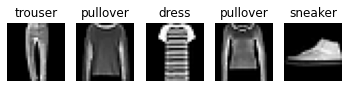

In [661]:
# number of images to plot
n = 5

# create a dictionary for the label names
labels = {
    0: 't-shirt',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'boot'
}


# Randomly sample n sample indices
rand_inds = np.random.randint(0, x_train.shape[0], n)

fig, axes = plt.subplots(ncols=n)
for i, ax in enumerate(axes):
    ax.imshow(x_train[rand_inds[i]], cmap='gray')
    ax.set_title(labels[y_train[rand_inds[i]]])
    ax.axis('off')

The class is currently a categorical variable with values 0 to 9. We need to convert this to a one-hot integer encoding.

In [662]:
# convert class category to one hot vector
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Build the model

We will construct a model in the same way as the previous example by composing layers starting with the input layer and ending with the output layer. However in this example, we will use [Conv2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers instead of Dense() layers as our hidden layers. In addition to specifying the number of neurons/filters and activation function for each Conv2D() layer, we need to specify the kernel size (the size of the convolutional kernel/filter). We will use $3\times3$ convolutions for all layers in this example. Each Conv2D() layer is followed by a [MaxPool2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer to enable invariance to small translations.

We will still use a Dense() layer for the final output layer. Previously we used the sigmoid activation in our final layer, but this is only used for binary classification outputs (0 to 1). Since this is a multi-class classification, we will use the [softmax function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) which returns the log odds for the multi-class case.

In [663]:
# Define the input layer
input_layer = keras.Input(shape=[x_train.shape[1], x_train.shape[2], 1])

# Define one hidden layer of Conv2D + Max Pooling
h1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(input_layer)
h1 = layers.MaxPooling2D(pool_size=(2, 2))(h1)

# Define a second Conv2D layer with 64 units, 3x3 kernel, and relu activation
h2 = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(h1)

# Define a second MaxPooling2D layer with 2x2 pool size
h2 = layers.MaxPooling2D(pool_size=(2, 2))(h2)

# Flatten the output from the last hidden layer so it can be passed to Dense layer
h2 = layers.Flatten()(h2)

# Final output layer
output = layers.Dense(num_classes, activation="softmax")(h2)

# Build the model specifying the input and output layer
model = keras.Model(inputs=input_layer, outputs=output)

We can plot our completed model to visualize the input, hidden, and output layers.

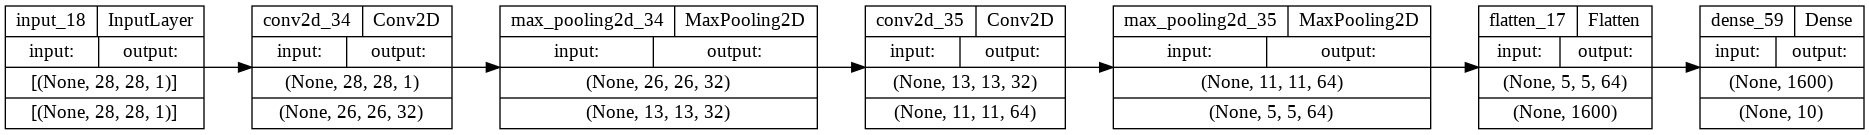

In [664]:
# `rankdir='LR'` is to make the graph horizontal
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Another way to visualize our model is to print a table of the layers and the shape of the representation at each layer using the `model.summary()` function.

In [665]:
model.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 1600)              0  

### Train the model

Now that we've constructed our model, we can compile and train the model as in the previous example. Since we are doing a multi-class classification, we use the [categorical cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/categorical_crossentropy) loss function instead of binary-cross entropy. 

In the first example, we created our own train/val/test subsets. In this example, the FashionMNIST dataset provided a train/test split but not a validation subset. We can have keras automatically split out a fraction of the training data using the `validation_split` argument to `model.fit()` as shown below.

In [666]:
batch_size = 512
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

model_result = model.fit(x_train, y_train, 
                         batch_size=batch_size,
                         epochs=epochs, 
                         validation_split=0.2)

Epoch 1/10
94/94 [==============================] - 32s 334ms/step - loss: 13.9555 - accuracy: 0.2237 - val_loss: 1.9591 - val_accuracy: 0.3773
Epoch 2/10
94/94 [==============================] - 33s 352ms/step - loss: 1.5469 - accuracy: 0.5068 - val_loss: 1.1200 - val_accuracy: 0.5926
Epoch 3/10
94/94 [==============================] - 32s 336ms/step - loss: 0.9673 - accuracy: 0.6524 - val_loss: 0.8872 - val_accuracy: 0.6873
Epoch 4/10
94/94 [==============================] - 32s 342ms/step - loss: 0.8173 - accuracy: 0.7097 - val_loss: 0.8796 - val_accuracy: 0.6812
Epoch 5/10
94/94 [==============================] - 31s 333ms/step - loss: 0.7361 - accuracy: 0.7386 - val_loss: 0.7467 - val_accuracy: 0.7310
Epoch 6/10
94/94 [==============================] - 32s 346ms/step - loss: 0.6870 - accuracy: 0.7554 - val_loss: 0.6725 - val_accuracy: 0.7639
Epoch 7/10
94/94 [==============================] - 31s 334ms/step - loss: 0.6514 - accuracy: 0.7682 - val_loss: 0.6887 - val_accuracy: 0.757

Create a figure with two subplots. The first subplot should plot the training and validation loss (`loss` and `val_loss`) and the second subplot should plot the training and validation accuracy (`accuracy` and `val_accuracy`). Make sure you include the axis labels and a legend in each plot.

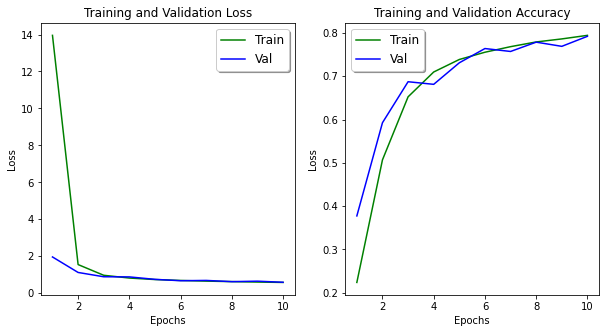

In [667]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
train_loss = model_result.history['loss']
val_loss = model_result.history['val_loss']
epochs = range(1, len(train_loss) + 1)
ax1.plot(epochs, train_loss, 'g', label='Train')
ax1.plot(epochs, val_loss, 'b', label = 'Val')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(shadow=True, fontsize='large')

train_accuracy = model_result.history['accuracy']
val_accuracy = model_result.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)
ax2.plot(epochs, train_accuracy, 'g', label='Train')
ax2.plot(epochs, val_accuracy, 'b', label = 'Val')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(shadow=True, fontsize='large')

Compute and print the test set accuracy. Note that your final accuracy may be different each time you run this due to the randomness in the validation split.

In [668]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Test accuracy:", test_acc)

Test accuracy: 0.7915999889373779
